# Introduction
This project focuses on the task of classifying images of fruits using Convolutional Neural Networks (CNNs). The goal is to explore different model architectures, preprocessing techniques, and evaluation strategies in order to identify the most effective method for image-based fruit classification.

This type of analysis is important because image classification plays a critical role in areas such as automated food sorting, agricultural monitoring, quality control, and retail automation. Accurate and efficient classification models can reduce manual labor, speed up processes, and improve consistency in systems that rely on visual inputs.

In our analysis, we aim to build and train a CNN model capable of distinguishing between multiple fruit types. We test different preprocessing strategies (resizing, normalization, augmentation) and compare the performance of a custom-built CNN with a pretrained ResNet18 model. Our goal is not only to reach high classification accuracy, but also to understand which techniques and model types work best under certain dataset constraints (e.g., size, variability, background noise).

Compared to similar works, this project offers the following advantages:

- We experiment with custom augmentations to simulate real-world variance in lighting and orientation, which is often missing from simpler classification tasks.

- We directly compare a lightweight CNN against a larger transfer learning model, providing insight into trade-offs between accuracy and computational cost.

- Our focus is on keeping the solution light and efficient, suitable for use in low-resource environments, such as embedded systems or mobile applications.

- What sets our solution apart is the combination of:

- Data-efficient design, making the most of a relatively small dataset;

- Transparent experimentation, clearly comparing how preprocessing and architecture choices affect performance;

- And a balanced approach that prioritizes both accuracy and practical deployment potential.

In [15]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



# Step 1: Data Analysis & Dataset Sample

### 1.1 Data Acquisition

The dataset used in this project is the [Fruits 360 dataset](https://www.kaggle.com/datasets/moltean/fruits), publicly available on Kaggle. It contains thousands of labeled fruit images in `.jpg` format, captured under controlled conditions and sorted into folders by class name. The images have a uniform size of **100x100 pixels**, and are in **RGB color format**.

We chose this dataset because:
- It includes a **wide variety of fruit classes**, allowing for multi-class classification.
- The images are already **clean and labeled**, reducing the need for manual annotation.
- It is commonly used in fruit classification tasks, making it suitable for **benchmarking**.
- Its structure (separate folders per class) works well with **PyTorch’s ImageFolder** loading system.

---

###  1.2 Data Tidying & Cleaning

Although the images are already organized by class, we manually selected **8 specific fruit categories** from the dataset to simplify and focus the classification task. For each class, we extracted both **training** and **test** images, keeping the original folder structure.

We then verified:
- The images were of correct size and format (**100x100, RGB**).
- Each class had a **sufficient and roughly balanced number** of samples.
- No corrupted or mislabeled files were present.

---

###  1.3 Class Distribution — Exploratory Data Analysis (EDA)

Before training any models, it's essential to examine the **distribution of classes** in both the training and test datasets. A well-balanced dataset ensures that the model learns equally from all classes, while an imbalanced dataset may lead to biased predictions.

We used two custom Python functions:
- `count_images_per_class(directory)` — counts how many images exist for each class.
- `display_class_distribution(class_counts)` — prints the class counts and shows a bar chart.

This analysis helps us:
- Verify that no class dominates the dataset.
- Ensure balanced training.
- Visually inspect class coverage before modeling.

 **Conclusion:** The dataset appears balanced across the 8 selected fruit classes, making it suitable for training a fair and generalizable classification model.

---

###  1.4 Dataset Summary

- **Source**: Fruits 360, Kaggle  
- **Selected classes**: 8 fruit types  
- **Image resolution**: 100 x 100 pixels  
- **Color channels**: RGB  
- **Total size**: ~several thousand images  
- **Split**: Separate training and test folders  


Training Set Distribution
Apple Red 1: 492 images
Avocado 1: 427 images
Banana 1: 490 images
Kaki 1: 490 images
Orange 1: 479 images
Pineapple 1: 490 images
Strawberry 1: 492 images
Tomato 1: 738 images


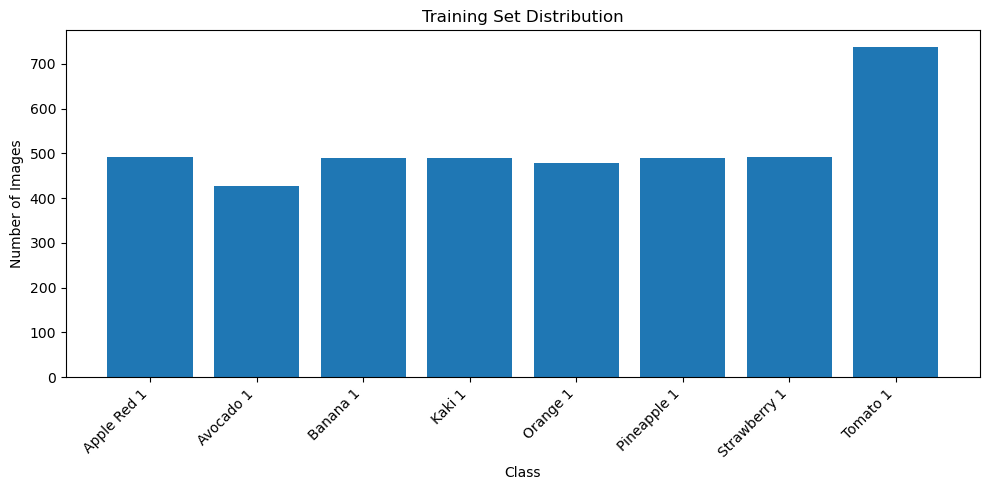

Test Set Distribution
Apple Red 1: 164 images
Avocado 1: 143 images
Banana 1: 166 images
Kiwi 1: 156 images
Orange 1: 160 images
Pineapple 1: 166 images
Strawberry 1: 164 images
Tomato 1: 246 images


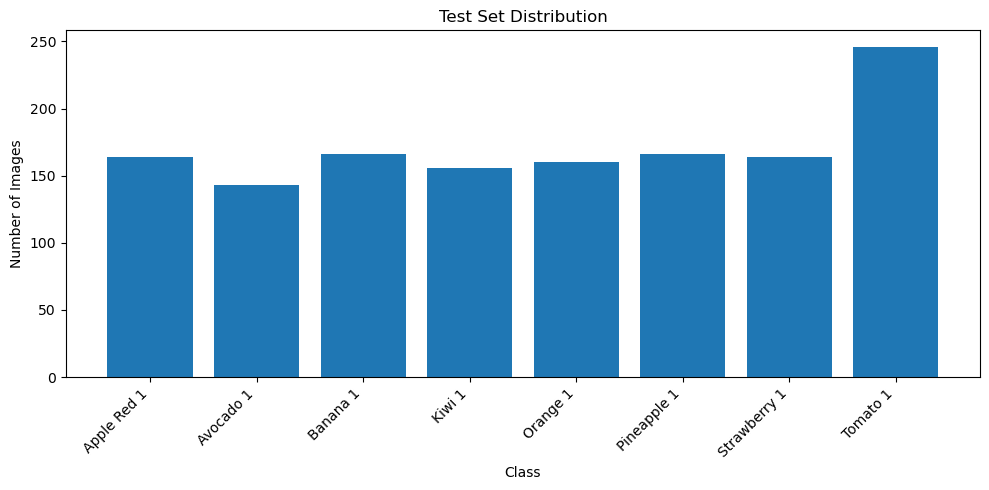

In [20]:

TRAIN_DIR = 'Dataset/Training'
TEST_DIR = 'Dataset/Test'

#Function to Count Images per Class
def count_images_per_class(directory):
    return {
        class_name: len(os.listdir(os.path.join(directory, class_name)))
        for class_name in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, class_name))
    }


###  Function to Display the Distribution (Text + Plot)
def display_class_distribution(class_counts, title="Class Distribution"):
    print(title)
    for cls, count in sorted(class_counts.items()):
        print(f"{cls}: {count} images")

    # Plot the distribution as a bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()  
    

train_counts = count_images_per_class(TRAIN_DIR)
test_counts = count_images_per_class(TEST_DIR)

display_class_distribution(train_counts, title="Training Set Distribution")
display_class_distribution(test_counts, title="Test Set Distribution")





# Step 2: Image Preprocessing & Dataset Loading

In this step, we prepare our fruit image dataset for training by applying different preprocessing strategies and loading the data using PyTorch utilities. Preprocessing is a critical stage that determines the format, variability, and structure of the inputs our CNN model will receive.

We explore **three preprocessing pipelines** to compare their impact on model performance later:

---

###  **Baseline RGB Preprocessing**

- All images are resized to **100x100 pixels**.
- Converted to **PyTorch tensors** and normalized to a pixel value range of `[-1, 1]` using `Normalize(mean=[0.5]*3, std=[0.5]*3)`.

This serves as our **control setup**, where we feed clean, untouched RGB images to the CNN.

---

###  **Augmented RGB Preprocessing**

This variant includes the same steps as the baseline, but adds random transformations:
- `RandomHorizontalFlip()`
- `RandomRotation(15 degrees)`
- `ColorJitter` (brightness, contrast, saturation)

These simulate real-world variability in lighting and orientation. This augmentation is applied **only to the training set** to help the model generalize better and avoid overfitting.

We expect this setup to potentially:
- Improve accuracy on the test set,
- Increase training time slightly due to added randomness.

---

###  **Grayscale Preprocessing**

In this setup, we convert all images to **grayscale** (`Grayscale(num_output_channels=1)`), reducing the number of input channels from 3 to 1.

Advantages we are testing:
- Potential **faster training** (fewer parameters in the CNN input layer),
- Simpler data that may still perform well if color is not critical.

This grayscale setup allows us to test:
- Whether **color information is necessary** for accurate fruit classification,
- If grayscale could be a **lighter and faster alternative** without big performance loss.

---

### Dataset Wrapping & Loading

Each version of the dataset (RGB, Augmented RGB, Grayscale) is wrapped using `ImageFolder` for automatic label assignment and structured loading.

We use `DataLoader` to:
- Batch the data (batch size = 32),
- Shuffle the training set (to avoid learning order bias),
- Efficiently feed data during training.

---

### Sample Visualization

We visualize a small batch from each dataset to:
- Confirm that preprocessing was applied correctly,
- Visually verify image quality and label correspondence,
- Ensure grayscale and augmentation steps were applied as intended.

---

### Purpose of This Step

By building **three parallel dataset pipelines**, we are setting up a controlled experiment to answer the following:

- Does **data augmentation** improve generalization in fruit classification?
- Can a **grayscale CNN** perform nearly as well as RGB, while being faster and lighter?
- What is the **best trade-off between accuracy, complexity, and speed**?

In the next steps, we will train the **same CNN architecture** on each version of the dataset and compare:
- Final test accuracy
- Training time
- Potential overfitting



 RGB Preview


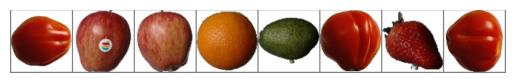

Image 1: Tomato 1
Image 2: Apple Red 1
Image 3: Apple Red 1
Image 4: Orange 1
Image 5: Avocado 1
Image 6: Tomato 1
Image 7: Strawberry 1
Image 8: Tomato 1

 Augmented RGB Preview


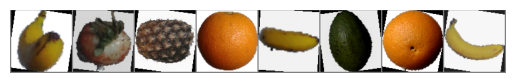

Image 1: Banana 1
Image 2: Strawberry 1
Image 3: Pineapple 1
Image 4: Orange 1
Image 5: Banana 1
Image 6: Avocado 1
Image 7: Orange 1
Image 8: Banana 1

 Grayscale Preview


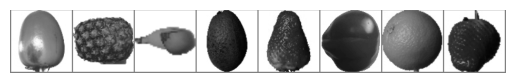

Image 1: Kaki 1
Image 2: Pineapple 1
Image 3: Banana 1
Image 4: Avocado 1
Image 5: Strawberry 1
Image 6: Tomato 1
Image 7: Orange 1
Image 8: Strawberry 1


In [22]:

    

# === Baseline RGB Preprocessing ===
transform_rgb = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# === Augmented RGB Preprocessing ===
transform_augmented = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# === Grayscale Preprocessing ===
transform_gray = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# === Load Datasets ===
train_data_rgb = ImageFolder(TRAIN_DIR, transform=transform_rgb)
test_data_rgb = ImageFolder(TEST_DIR, transform=transform_rgb)

train_data_aug = ImageFolder(TRAIN_DIR, transform=transform_augmented)
test_data_aug = ImageFolder(TEST_DIR, transform=transform_rgb)  # No need to augment test data

train_data_gray = ImageFolder(TRAIN_DIR, transform=transform_gray)
test_data_gray = ImageFolder(TEST_DIR, transform=transform_gray)

# === DataLoaders ===
train_loader_rgb = DataLoader(train_data_rgb, batch_size=32, shuffle=True)
test_loader_rgb = DataLoader(test_data_rgb, batch_size=32, shuffle=False)

train_loader_aug = DataLoader(train_data_aug, batch_size=32, shuffle=True)
test_loader_aug = DataLoader(test_data_aug, batch_size=32, shuffle=False)

train_loader_gray = DataLoader(train_data_gray, batch_size=32, shuffle=True)
test_loader_gray = DataLoader(test_data_gray, batch_size=32, shuffle=False)

# === Visualization Utility ===
def imshow(img, grayscale=False):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if grayscale:
        npimg = npimg[0]  # single channel
        plt.imshow(npimg, cmap='gray')
    else:
        npimg = np.transpose(npimg, (1, 2, 0))  # RGB
        plt.imshow(npimg)
    plt.axis('off')
    plt.show()

# === Show Sample Images from RGB, Augmented, and Grayscale ===

print(" RGB Preview")
images, labels = next(iter(train_loader_rgb))
imshow(torchvision.utils.make_grid(images[:8]))
for i in range(8):
    print(f"Image {i+1}: {train_data_rgb.classes[labels[i]]}")

print("\n Augmented RGB Preview")
images, labels = next(iter(train_loader_aug))
imshow(torchvision.utils.make_grid(images[:8]))
for i in range(8):
    print(f"Image {i+1}: {train_data_aug.classes[labels[i]]}")

print("\n Grayscale Preview")
images, labels = next(iter(train_loader_gray))
imshow(torchvision.utils.make_grid(images[:8]), grayscale=True)
for i in range(8):
    print(f"Image {i+1}: {train_data_gray.classes[labels[i]]}")

# Step 3. Model Building — Baseline CNN

### In this step, we define and train our first convolutional neural network (CNN) model:

1. **Define the CNN architecture**

   - The model includes three convolutional layers followed by pooling, and two fully connected layers.  
   - ReLU activation and dropout are used to encourage non-linearity and prevent overfitting.

2. **Specify the training configuration**

   - We use cross-entropy loss as our objective function (suitable for multi-class classification).  
   - The Adam optimizer is chosen for its adaptive learning rate and efficiency.

3. **Train the model over multiple epochs**

   - For each epoch, we iterate through the training data, update model weights, and compute the training loss.  
   - We also evaluate model accuracy on the test set after each epoch.

4. **Track and visualize learning progress**

   - We plot the training loss and test accuracy over time to understand how the model is learning.  
   - This helps diagnose underfitting, overfitting, or training instability.

5. **Purpose of this step**

   - To validate *Hypothesis 1*: whether a basic CNN is able to classify fruit images into 8 categories with reasonable accuracy.  
   - This gives us a baseline to later compare with improved versions (e.g., data augmentation).


Epoch [1/10], Loss: 30.6932, Test Accuracy: 0.9084
Epoch [2/10], Loss: 0.9663, Test Accuracy: 0.8791
Epoch [3/10], Loss: 0.7386, Test Accuracy: 0.8974
Epoch [4/10], Loss: 0.1852, Test Accuracy: 0.9260
Epoch [5/10], Loss: 5.5228, Test Accuracy: 0.8857
Epoch [6/10], Loss: 0.0612, Test Accuracy: 0.8857
Epoch [7/10], Loss: 0.0214, Test Accuracy: 0.8857
Epoch [8/10], Loss: 0.1582, Test Accuracy: 0.8857
Epoch [9/10], Loss: 0.0343, Test Accuracy: 0.8857
Epoch [10/10], Loss: 0.0108, Test Accuracy: 0.8857


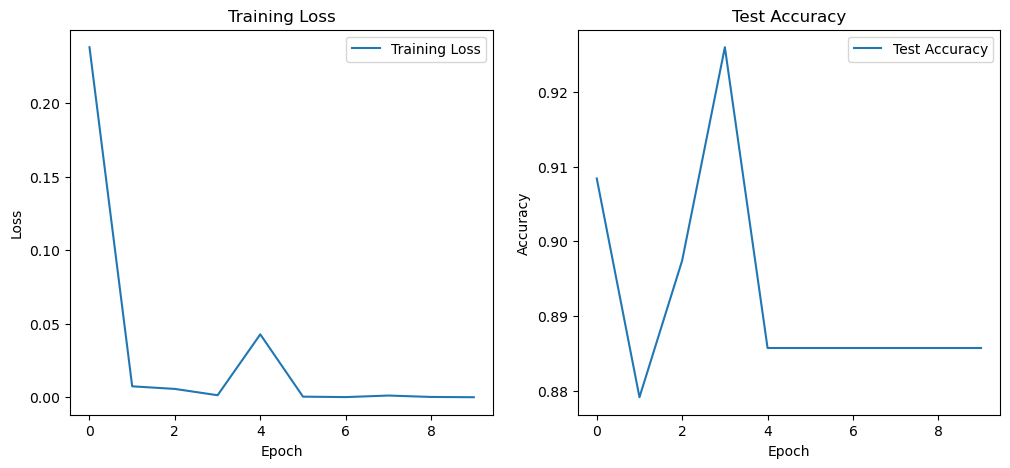

In [18]:
# Define a Simple CNN Architecture
# Baseline CNN Model
class FruitCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(FruitCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input: 3x100x100 → 16x100x100
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # → 16x50x50

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # → 32x50x50
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # → 32x25x25

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # → 64x25x25
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                           # → 64x12x12
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
#  Initialize Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FruitCNN(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return train_losses, test_accuracies

# Run the Training
train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

# Save the trained model to a file
torch.save(model.state_dict(), "fruit_cnn_baseline.pth")

# Plot Training Loss and Accuracy

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()


# Step 4. Model Evaluation & Metrics

### In this step, we evaluate our trained CNN to assess whether it meets the expectations of Hypothesis 1:
> *"A convolutional neural network (CNN) can accurately classify fruit images into 8 classes."*

We perform the following evaluations:

1. **Classification Report**
   - Computes precision, recall, F1-score for each fruit class.
   - Helps us understand how well the model predicts each category.

2. **Confusion Matrix**
   - A matrix showing how often classes are correctly or incorrectly predicted.
   - Reveals patterns of misclassification between similar-looking fruits.

3. **Overall Accuracy**
   - The percentage of correctly predicted images in the test set.

These metrics provide insight into the model's strengths and weaknesses, and allow us to determine whether the model is suitable for real-world use or needs further improvement.


Classification Report:
              precision    recall  f1-score   support

 Apple Red 1       0.67      1.00      0.80       164
   Avocado 1       1.00      1.00      1.00       143
    Banana 1       1.00      1.00      1.00       166
      Kiwi 1       0.00      0.00      0.00       156
    Orange 1       1.00      1.00      1.00       160
 Pineapple 1       0.78      1.00      0.87       166
Strawberry 1       0.86      1.00      0.92       164
    Tomato 1       1.00      1.00      1.00       246

    accuracy                           0.89      1365
   macro avg       0.79      0.88      0.82      1365
weighted avg       0.80      0.89      0.84      1365



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


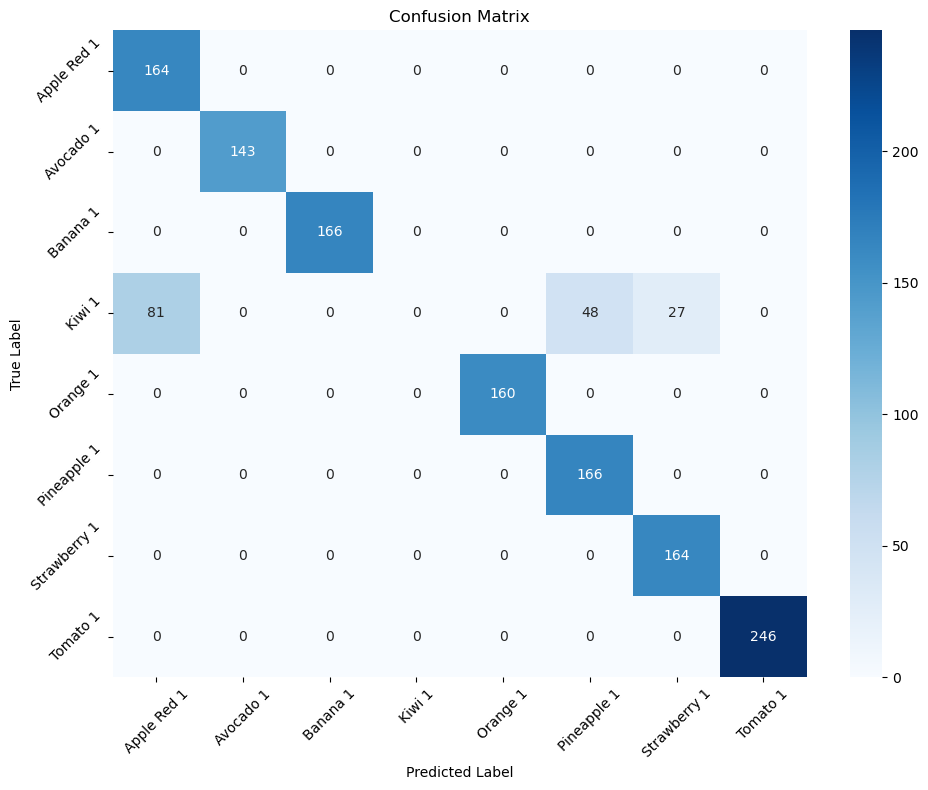

In [19]:
# Put model in evaluation mode
model.eval()

# Gather predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get class names from dataset
class_names = test_data.classes

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()